In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [4]:
# First, lets load the dataset
data_train = dset.SVHN('../data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('../data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

In [5]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [6]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


In [7]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

In [164]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None, scheduler_for_batch=False):

    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
            
            if scheduler is not None and scheduler_for_batch:
                scheduler.step()

        if scheduler is not None and not scheduler_for_batch:
            scheduler.step()

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Epoch: %i, Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (epoch, ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!

    correct_samples = 0
    total_samples = 0
    for i_step, (x, y) in enumerate(loader):
        prediction = model(x)
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]
    return float(correct_samples) / total_samples

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Epoch: 0, Average loss: 1.690043, Train accuracy: 0.514009, Val accuracy: 0.519555
Epoch: 1, Average loss: 1.690514, Train accuracy: 0.513633, Val accuracy: 0.522490
Epoch: 2, Average loss: 1.689489, Train accuracy: 0.516005, Val accuracy: 0.529179


In [13]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Epoch: 0, Average loss: 2.173321, Train accuracy: 0.204928, Val accuracy: 0.238687
Epoch: 1, Average loss: 1.980379, Train accuracy: 0.294390, Val accuracy: 0.353150
Epoch: 2, Average loss: 1.786860, Train accuracy: 0.382282, Val accuracy: 0.398130


In [14]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Epoch: 0, Average loss: 1.749776, Train accuracy: 0.468331, Val accuracy: 0.558051
Epoch: 1, Average loss: 1.614925, Train accuracy: 0.549517, Val accuracy: 0.571633
Epoch: 2, Average loss: 1.666352, Train accuracy: 0.543903, Val accuracy: 0.548017


In [165]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, 0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3, scheduler=scheduler)

Epoch: 0, Average loss: 1.767385, Train accuracy: 0.454766, Val accuracy: 0.533206
Epoch: 1, Average loss: 1.624255, Train accuracy: 0.542794, Val accuracy: 0.518190
Epoch: 2, Average loss: 1.610201, Train accuracy: 0.572399, Val accuracy: 0.567333


In [126]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    
    ground_truth = np.array([], np.int)
    predictions = np.array([], np.int)
    sampler = SubsetSampler(indices)
    for _, i in enumerate(sampler):
        x, y = dataset[i]
        X = x.view(1, -1)
        pred = model(X)
        y_pred = torch.argmax(pred)
        
        ground_truth = np.append(ground_truth, y)
        predictions = np.append(predictions, y_pred)
    
    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

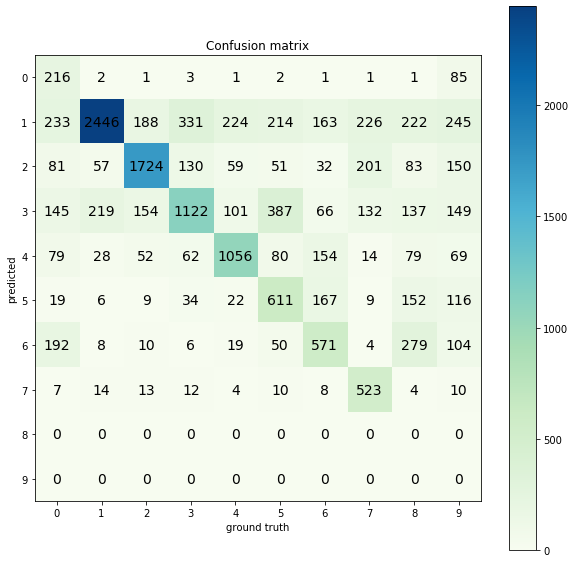

In [84]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    
    # TODO: Implement filling the prediction matrix
    #return np.array([[40, 2, 3], [10, 50,0], [0, 2, 80]])
    
    for n_iter in range(len(ground_truth)):
        i = predictions[n_iter]
        j = ground_truth[n_iter]
        confusion_matrix[i][j] += 1
    
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

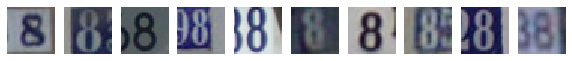

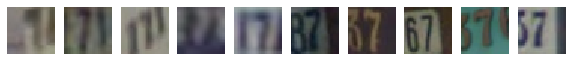

In [131]:
data_train_images = dset.SVHN('../data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, ground_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    
    #confusion_matrix = build_confusion_matrix(predictions, groud_truth)
    #print(confusion_matrix[predicted_class][gt_class])
    
    indices = []
    for n_iter in range(len(ground_truth)):
        if predictions[n_iter] == predicted_class and ground_truth[n_iter] == gt_class:
            indices.append(val_indices[n_iter])
    visualize_images(indices, data)
    
visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

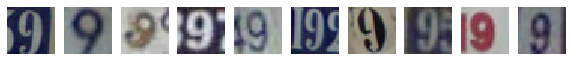

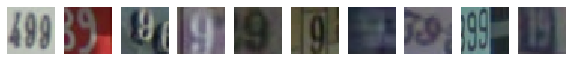

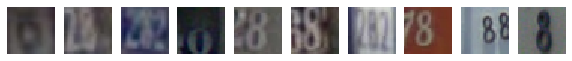

In [138]:
visualize_predicted_actual(0, 9, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 9, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 8, predictions, gt, np.array(val_indices), data_train_images)

Epoch: 0, Average loss: 1.639027, Train accuracy: 0.471215, Val accuracy: 0.619070
Epoch: 1, Average loss: 1.210128, Train accuracy: 0.641248, Val accuracy: 0.661661
Epoch: 2, Average loss: 1.071878, Train accuracy: 0.684196, Val accuracy: 0.682411
Epoch: 3, Average loss: 0.991678, Train accuracy: 0.708238, Val accuracy: 0.713740
Epoch: 4, Average loss: 0.924164, Train accuracy: 0.730403, Val accuracy: 0.750392
Epoch: 5, Average loss: 0.866356, Train accuracy: 0.747278, Val accuracy: 0.740018
Epoch: 6, Average loss: 0.823971, Train accuracy: 0.762430, Val accuracy: 0.772029
Epoch: 7, Average loss: 0.786733, Train accuracy: 0.773999, Val accuracy: 0.780834
Epoch: 8, Average loss: 0.763264, Train accuracy: 0.784459, Val accuracy: 0.790458
Epoch: 9, Average loss: 0.746620, Train accuracy: 0.790431, Val accuracy: 0.795168
Test accuracy: 0.7689


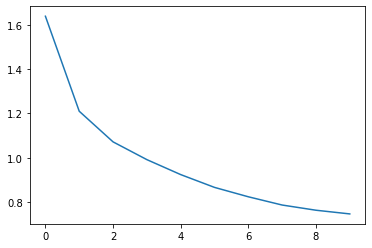

In [183]:
batch_size = 64
lr = 1e-2
epoch = 10
l2 = 1e-2


data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(inplace=True),
    
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(inplace=True),
    
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
nn_model.apply(init_normal)

loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=lr, weight_decay=l2)
#optimizer = optim.Adam(nn_model.parameters(), lr=lr, weight_decay=l2)
#optimizer = optim.Adagrad(nn_model.parameters(), lr=lr, weight_decay=l2)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epoch, eta_min=0)
loss_history, train_history, val_history = train_model(nn_model, 
                                                       train_loader, 
                                                       val_loader, 
                                                       loss, 
                                                       optimizer, 
                                                       epoch, 
                                                       scheduler=scheduler
                                                       )

test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)
plt.plot(loss_history)

Epoch: 0, Average loss: 1.337423, Train accuracy: 0.561871, Val accuracy: 0.713194
Epoch: 1, Average loss: 0.922277, Train accuracy: 0.713920, Val accuracy: 0.761177
Epoch: 2, Average loss: 0.801135, Train accuracy: 0.753404, Val accuracy: 0.778036
Epoch: 3, Average loss: 0.727883, Train accuracy: 0.776695, Val accuracy: 0.788888
Epoch: 4, Average loss: 0.669114, Train accuracy: 0.794219, Val accuracy: 0.807590
Epoch: 5, Average loss: 0.620497, Train accuracy: 0.809098, Val accuracy: 0.825268
Epoch: 6, Average loss: 0.574606, Train accuracy: 0.822441, Val accuracy: 0.827043
Epoch: 7, Average loss: 0.535792, Train accuracy: 0.835716, Val accuracy: 0.838441
Epoch: 8, Average loss: 0.499448, Train accuracy: 0.847524, Val accuracy: 0.842263
Epoch: 9, Average loss: 0.481486, Train accuracy: 0.852660, Val accuracy: 0.846768
Test accuracy: 0.8211


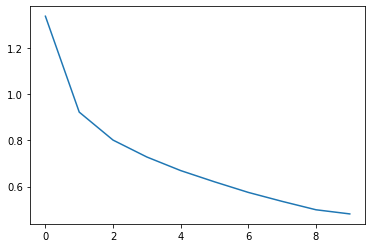

In [185]:
batch_size = 64
lr = 1e-2
epoch = 10
l2 = 1e-6


data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(inplace=True),
    
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(inplace=True),
    
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
nn_model.apply(init_normal)

loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
#optimizer = optim.SGD(nn_model.parameters(), lr=lr, weight_decay=l2)
optimizer = optim.Adam(nn_model.parameters(), lr=lr, weight_decay=l2)
#optimizer = optim.Adagrad(nn_model.parameters(), lr=lr, weight_decay=l2)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epoch, eta_min=0)
loss_history, train_history, val_history = train_model(nn_model, 
                                                       train_loader, 
                                                       val_loader, 
                                                       loss, 
                                                       optimizer, 
                                                       epoch, 
                                                       scheduler=scheduler
                                                       )

test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)
plt.plot(loss_history)

Epoch: 0, Average loss: 1.360949, Train accuracy: 0.549705, Val accuracy: 0.705140
Epoch: 1, Average loss: 0.953388, Train accuracy: 0.702266, Val accuracy: 0.746707
Epoch: 2, Average loss: 0.834419, Train accuracy: 0.742074, Val accuracy: 0.780629
Epoch: 3, Average loss: 0.749273, Train accuracy: 0.769972, Val accuracy: 0.793256
Epoch: 4, Average loss: 0.699409, Train accuracy: 0.784578, Val accuracy: 0.807453
Epoch: 5, Average loss: 0.652120, Train accuracy: 0.799679, Val accuracy: 0.822060
Epoch: 6, Average loss: 0.610221, Train accuracy: 0.811214, Val accuracy: 0.831479
Epoch: 7, Average loss: 0.577089, Train accuracy: 0.821759, Val accuracy: 0.838236
Epoch: 8, Average loss: 0.535913, Train accuracy: 0.834949, Val accuracy: 0.838441
Epoch: 9, Average loss: 0.502844, Train accuracy: 0.844845, Val accuracy: 0.843082
Epoch: 10, Average loss: 0.476865, Train accuracy: 0.852899, Val accuracy: 0.848543
Epoch: 11, Average loss: 0.456370, Train accuracy: 0.860509, Val accuracy: 0.851955
Ep

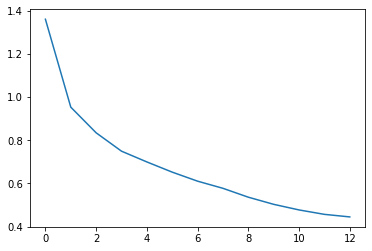

In [214]:
batch_size = 64
lr = 1e-2
epoch = 13
l2 = 1e-6


data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(inplace=True),
    
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(inplace=True),
    
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
nn_model.apply(init_normal)

loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
#optimizer = optim.SGD(nn_model.parameters(), lr=lr, weight_decay=l2)
optimizer = optim.Adam(nn_model.parameters(), lr=lr, weight_decay=l2)
#optimizer = optim.Adagrad(nn_model.parameters(), lr=lr, weight_decay=l2)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epoch, eta_min=0)
loss_history, train_history, val_history = train_model(nn_model, 
                                                       train_loader, 
                                                       val_loader, 
                                                       loss, 
                                                       optimizer, 
                                                       epoch, 
                                                       scheduler=scheduler
                                                       )

test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)
plt.plot(loss_history)

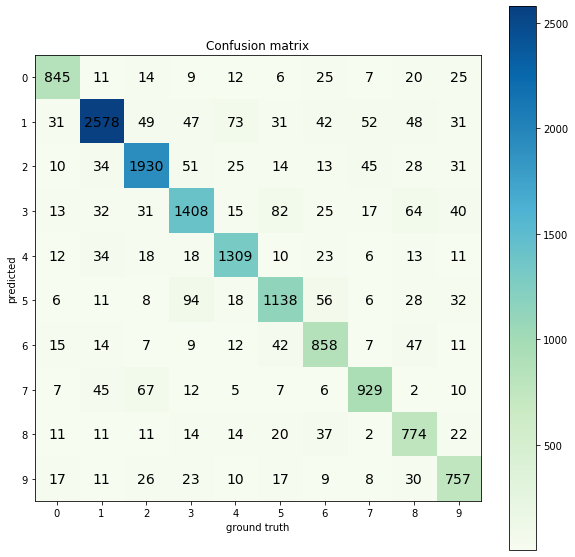

In [215]:
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)